In [ ]:
import sys
!conda install --yes --prefix {sys.prefix} matplotlib

In [ ]:
# Graph to compare min and max finish time amongst all of the metrics
% matplotlib inline
import matplotlib.pyplot as plt
import math
import json
import os
import datetime

# Extracts statistics from the data object which is an array of job dictionaries
# processes stat if necessary
def extract_stat(data_obj, stat_x, stat_y):
    stats_x = []
    stats_y = []
    for job in data_obj:
        stat_value_x = None
        stat_value_y = None
        # Account for stats in which two values need to be subtracted
        if isinstance(stat_x, tuple):
            stat_value_x = abs(job[stat_x[0]] - job[stat_x[1]])
        if isinstance(stat_y, tuple):
            stat_value_y = abs(job[stat_y[0]] - job[stat_y[1]])
        if not stat_value_x:
            stat_value_x = job[stat_x]
        if not stat_value_y:
            stat_value_y = job[stat_y]
            
        stats_x.append(stat_value_x)
        stats_y.append(stat_value_y)
    return (max(stats_x), max(stats_y))

# generates a graph that compares the given metrics with the 2 statistics
# 
# metrics - The list of metrics
# stat_x - The name of the stat as shown in the json. If the stat contains a tuple of 2, the difference
# of the first and second in the tuple will be used.
# stat_y - The name of the other stat as shown in the json
def generate_comparison(metrics, stat_x, stat_y):

    n_groups=16
    fig, ax = plt.subplots(figsize=(15,10))

    index = np.arange(n_groups)
    bar_width = 0.2

    opacity = 0.4
    error_config = {'ecolor': '0.3'}

    metric_stats = {}
    for metric in metrics:
        metric_stats[metric] = {stat_x: None, stat_y:None}
        data_files = get_associated_files(metric)
        stat_values_x = []
        stat_values_y = []
        for data_file in data_files:
            # Compile the data file path
            data_file_path = os.path.join(cwd, stats_dir)
            fp = open(pathed)
            data_obj = json.load(fp)
            stat_value_x, stat_value_y = extract_stat(data_obj, stat_x, stat_y)
            stat_values_x.append(stat_value_x)
            stat_values_y.append(stat_value_y)
        metric_stats[metric][stat_x] = max(stat_values_x)
        metric_stats[metric][stat_y] = max(stat_values_y)
        
    #for: TODO, add a line for each metric instead of bar
        rects1 = ax.bar(x, [math.log(i,10) for i in y1], bar_width,
                        alpha=opacity,
                        error_kw=error_config,
                        label='Dataframe')

    ax.set_xlabel('Job Number (Determines Memory Setting)')
    ax.set_ylabel('Peak Memory (Log Base 10)')
    ax.set_title('Peak Execution Memory for Each Memory Setting')
    ax.set_xticks(1 + index + bar_width)
    ax.set_xticklabels(x)
    ax.legend()

    fig.tight_layout()
    plt.show()

In [1]:
# Script to get JSON data from 
import re
import matplotlib.pyplot as plt
import json
import os
import datetime
import numpy as np
import seaborn as sns
import pandas as pd
pd.set_option('display.max_columns', 500)

cwd = os.getcwd()

#@MARIAMA - If you move spark-stats directory in all to the parent directory (what is base_dir below), then
#you should be able to get rid of the following if statement.
#Make sure you pull from master.  There is a new metrics directory in the parent directory, so do NOT pull
#metrics from the all directory.

stats_dir = "spark-stats"
metrics_dir = "metrics"
cluster_stats="cluster-spark-stats"
cluster_metrics="cluster_metrics"
base_dir = os.path.dirname(cwd)

#provides an absolute path to spark-stats directory
spark_stats_dir=""
#provides an absolute path to metrics directory (the run-output files)
spark_metrics_dir=""
cluster_stats_dir=""
cluster_metrics_dir=""
if(cwd.startswith("C")): #On a Windows
    spark_stats_dir = base_dir + "\\" + stats_dir
    spark_metrics_dir = base_dir + "\\" + metrics_dir
    cluster_stats_dir = base_dir + "\\" + cluster_stats
    cluster_metrics_dir = base_dir + "\\" + cluster_metrics
else:
    spark_stats_dir = base_dir + "/" + stats_dir
    spark_metrics_dir = base_dir + "/" + metrics_dir
    cluster_stats_dir = base_dir + "/" + cluster_stats
    cluster_metrics_dir = base_dir + "/" + cluster_metrics

metric_output_mapping = {
    "basic-dataframe-run-output": "BasicDataframe",
    "basic-dataset-run-output": "BasicDataset",
    "basic-rdd-run-output": "BasicRDD",
    "cache-dataframe-run-output": "CacheDataframe",
    "cache-dataset-run-output": "CacheDataset",
    "cache-rdd-run-output": "CacheRDD",
    "kmeans-dataframe-run-output": "KMeansDataframe",
    "kmeans-dataset-run-output": "KMeansDataset",
    "map-partitions-rdd-run-output": "MapPartitionsRDD",
    "map-rdd-run-output": "MapRDD",
    "partition-dataframe-run-output": "PartitionDataframe",
    "parititon-dataset-run-output": "PartitionDataset",
    "partition-rdd-run-output": "PartitionRDD"
}

#Invert the above mapping
metric_output_mapping_inv = {v: k for k, v in metric_output_mapping.items()}

#Given spark-stats app name, get the file name
def get_spark_stats_file(appName):
    if(cwd.startswith("C")):
        return spark_stats_dir + "\\" + appName
    else:
        return spark_stats_dir + "/" + appName

#Given the metrics output name, get the file name
def get_metrics_file(fileName):
    if(cwd.startswith("C")):
        return spark_metrics_dir + "\\" + fileName
    else:
        return spark_metrics_dir + "/" + fileName

#Given a run-output file name (in metrics directory), get the appNames associated with that run
def get_associated_appnames(run_output_name):
    valid_files = list(pd.read_csv(get_metrics_file(run_output_name))["appName"])
    return [a_file for a_file in os.listdir(spark_stats_dir) if a_file in valid_files]

#Given an appName (also a file name in the spark-stats directory), get the run parameters associated with that run
def get_run_params(appName):
    for beginningOutput in metric_output_mapping_inv:
        if appName.startswith(beginningOutput):
            metrics_df = pd.read_csv(get_metrics_file(metric_output_mapping_inv[beginningOutput]))
            return metrics_df[metrics_df["appName"] == appName]

#Sort the metrics dataframe by threadCount, then executorMem, then overheadMem.  This will only apply to local jobs as is
def metrics_df_sort(metrics_df):
    return metrics_df.sort_values(by=['threadCount', 'executorMem', 'overheadMem'])

#Get the metrics dataframe for the specified run-output file name. Then clean up and sort  This will only apply to local jobs as is
def get_metrics(run_output_name):
    raw_metrics = pd.read_csv(get_metrics_file(run_output_name))
    raw_metrics["executorMem"] = raw_metrics["executorMem"].apply(lambda x: int(x[:-1]))
    raw_metrics["overheadMem"] = raw_metrics["overheadMem"].apply(lambda x: int(x[:-1]))
    return raw_metrics

#Given an app name (file name in spark-stats since they match), get the dataframe for that app name
def get_spark_stats(appName):
    return pd.read_json(get_spark_stats_file(appName))

print(cwd)
print(base_dir)
print(get_associated_appnames("basic-dataframe-run-output"))

/Users/bnicholls/Documents/School/cmsc611-project/python_scripts
/Users/bnicholls/Documents/School/cmsc611-project
['BasicDataframeRunner-2018-12-09T07:27:23.1544340443Z', 'BasicDataframeRunner-2018-12-09T07:30:52.1544340652Z', 'BasicDataframeRunner-2018-12-09T07:12:34.1544339554Z', 'BasicDataframeRunner-2018-12-09T07:32:57.1544340777Z', 'BasicDataframeRunner-2018-12-09T07:20:38.1544340038Z', 'BasicDataframeRunner-2018-12-09T07:35:01.1544340901Z', 'BasicDataframeRunner-2018-12-09T07:17:42.1544339862Z', 'BasicDataframeRunner-2018-12-09T07:15:07.1544339707Z', 'BasicDataframeRunner-2018-12-09T07:09:59.1544339399Z', 'BasicDataframeRunner-2018-12-09T07:33:59.1544340839Z', 'BasicDataframeRunner-2018-12-09T07:25:05.1544340305Z', 'BasicDataframeRunner-2018-12-09T07:07:23.1544339243Z', 'BasicDataframeRunner-2018-12-09T07:23:36.1544340216Z', 'BasicDataframeRunner-2018-12-09T07:28:33.1544340513Z', 'BasicDataframeRunner-2018-12-09T07:22:07.1544340127Z', 'BasicDataframeRunner-2018-12-09T07:29:42.15

In [2]:
#Just messing around. The output in this paragraph is a list of the stats available to be used
map_partitions_files = get_associated_appnames("map-partitions-rdd-run-output")
map_files = get_associated_appnames("map-rdd-run-output")
print(map_partitions_files)
print(map_files)
sample = pd.read_json(get_spark_stats_file(map_partitions_files[0]))
list(sample)

['MapPartitionsRDDRunner-2018-12-09T05:42:18.1544334138Z', 'MapPartitionsRDDRunner-2018-12-09T05:02:38.1544331758Z', 'MapPartitionsRDDRunner-2018-12-09T05:36:42.1544333802Z', 'MapPartitionsRDDRunner-2018-12-09T05:26:11.1544333171Z', 'MapPartitionsRDDRunner-2018-12-09T05:09:30.1544332170Z', 'MapPartitionsRDDRunner-2018-12-09T05:20:06.1544332806Z', 'MapPartitionsRDDRunner-2018-12-09T04:46:57.1544330817Z', 'MapPartitionsRDDRunner-2018-12-09T05:29:11.1544333351Z', 'MapPartitionsRDDRunner-2018-12-09T05:45:20.1544334320Z', 'MapPartitionsRDDRunner-2018-12-09T04:57:14.1544331434Z', 'MapPartitionsRDDRunner-2018-12-09T05:48:22.1544334502Z', 'MapPartitionsRDDRunner-2018-12-09T05:13:00.1544332380Z', 'MapPartitionsRDDRunner-2018-12-09T04:52:08.1544331128Z', 'MapPartitionsRDDRunner-2018-12-09T04:41:49.1544330509Z', 'MapPartitionsRDDRunner-2018-12-09T05:33:43.1544333623Z', 'MapPartitionsRDDRunner-2018-12-09T05:16:29.1544332589Z']
['MapRDDRunner-2018-12-09T06:21:45.1544336505Z', 'MapRDDRunner-2018-12-

['bytesRead',
 'bytesWritten',
 'diskBytesSpilled',
 'duration',
 'executorCpuTime',
 'executorDeserializeCpuTime',
 'executorDeserializeTime',
 'executorId',
 'executorRunTime',
 'finishTime',
 'gettingResultTime',
 'host',
 'index',
 'jobGroup',
 'jobId',
 'jvmGCTime',
 'launchTime',
 'memoryBytesSpilled',
 'numUpdatedBlockStatuses',
 'peakExecutionMemory',
 'recordsRead',
 'recordsWritten',
 'resultSerializationTime',
 'resultSize',
 'schedulerDelay',
 'shuffleBytesWritten',
 'shuffleFetchWaitTime',
 'shuffleLocalBlocksFetched',
 'shuffleRecordsWritten',
 'shuffleRemoteBlocksFetched',
 'shuffleTotalBlocksFetched',
 'shuffleTotalBytesRead',
 'shuffleWriteTime',
 'speculative',
 'stageId',
 'successful',
 'taskLocality']

In [3]:
sample["stageId"].value_counts()

1    12834
0    12834
Name: stageId, dtype: int64

In [4]:
# Given the spark-stats dataframe, find the start time, end time, and run duration time in millis for the dataframe
def get_full_execution_time(df):
    start_time = min(df["launchTime"])
    end_time = max(df["finishTime"])
    time_range = end_time - start_time
    return (start_time, end_time, time_range)

# Given the spark-stats dataframe, calculate the total cpu time for the job
def get_full_cpu_time(df):
    return df["executorCpuTime"].sum()

# Given the spark-stats dataframe, calculate the max peakExecutionMemory for the job
def get_max_peakExecutionMemory(df):
    return max(df["peakExecutionMemory"])

# Given the spark-stats dataframe, calculate the min peakExecutionMemory for the job
def get_min_peakExecutionMemory(df):
    return min(df["peakExecutionMemory"])

In [5]:
t = get_full_execution_time(sample)

In [6]:
t

(1544334253692, 1544334316578, 62886)

In [7]:
get_run_params(map_partitions_files[0])

,appName,threadCount,executorMem,overheadMem
13,MapPartitionsRDDRunner-2018-12-09T05:42:18.154...,4,1024m,384m


In [8]:
def generate_graph(data, xlabel, ylabel, title, savefig="graph.png"):
    ax = sns.lineplot(data=data, linewidth=2.5)
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
    plt.savefig("images/"+ savefig)

    #Cleanup the plot that we just printed so the one below doesn't have extra data
    plt.cla()

In [ ]:
# Map Partitions RDD vs Map RDD
# Line plot of the job num vs execution time
# Note that basic-rdd and map-partitions are the exact same.  They were just labelled differently.
# I was curious to see if they exhibited the same run times, but they don't.  I don't know how to explain the differences
mapPartitions_vs_map_df = {
    "BasicRDD": get_metrics("basic-rdd-run-output")["appName"].apply(lambda appName:get_full_execution_time(get_spark_stats(appName))[2]/1000.0),
    "MapPartitions": get_metrics("map-partitions-rdd-run-output")["appName"].apply(lambda appName:get_full_execution_time(get_spark_stats(appName))[2]/1000.0),
    "Map": get_metrics("map-rdd-run-output")["appName"].apply(lambda appName:get_full_execution_time(get_spark_stats(appName))[2]/1000.0),  
}
data = pd.DataFrame(mapPartitions_vs_map_df)

#Create a line plot for all 3 jobs.  This is what shows there are weird anomalies in the execution time for the 
# mapPartitions/basicRDD jobs
generate_graph(data, "Job Number", "Total Execution Time (sec)", title="Execution Time Comparison When\nUsing Map vs MapPartitions vs BasicRDD", savefig="mapVsMapPartitionsAllExecutionTime.png")

#Cleanup the plot that we just printed so the one below doesn't have extra data
plt.cla()

#Now do cleanup. Since BasicRDD and MapParitions are the same job, let's just take the minimum execution time
#to compare to the execution time of the map job.
data["MapPartitions"] = data[["MapPartitions", "BasicRDD"]].min(axis=1)
data = data.drop(["BasicRDD"], axis=1)

generate_graph(data, "Job Number", "Total Execution Time (sec)", title="Execution Time Comparison When Using Map vs MapPartitions", savefig="mapVsMapPartitionsBestExecutionTime.png")

In [ ]:
# I wanted to see what comparing the CPU Time would look like.
mapPartitions_vs_map_df = {
    "BasicRDD": get_metrics("basic-rdd-run-output")["appName"].apply(lambda appName:get_full_cpu_time(get_spark_stats(appName))),
    "MapPartitions": get_metrics("map-partitions-rdd-run-output")["appName"].apply(lambda appName:get_full_cpu_time(get_spark_stats(appName))),
    "Map": get_metrics("map-rdd-run-output")["appName"].apply(lambda appName:get_full_cpu_time(get_spark_stats(appName))),  
}
data = pd.DataFrame(mapPartitions_vs_map_df)

#Again, just seeing how BasicRDD and MapPartitions jobs compare.
generate_graph(data, "Job Number", "Total CPU Time of Executors (sec)", 
               title="CPU Execution Time Comparison When\nUsing Map vs MapPartitions vs BasicRDD", savefig="mapVsMapPartitionsAllCpuTime.png")

#Now, just seeing how minimum CPU Time of BasicRDD and MapPartitions jobs compare to the Map job.
data["MapPartitions"] = data[["MapPartitions", "BasicRDD"]].min(axis=1)
data = data.drop(["BasicRDD"], axis=1)

generate_graph(data, "Job Number", "Total CPU Time of Executors (sec)", 
               title="CPU Execution Time Comparison When Using Map vs MapPartitions", savefig="mapVsMapPartitionsBestCpuTime.png")


In [ ]:
# Now I'm comparing the max peak execution memory of the mapParititons and the map jobs.
mapPartitions_vs_map_df = {
    "MapPartitions": get_metrics("map-partitions-rdd-run-output")["appName"].apply(lambda appName:get_max_peakExecutionMemory(get_spark_stats(appName))),
    "Map": get_metrics("map-rdd-run-output")["appName"].apply(lambda appName:get_max_peakExecutionMemory(get_spark_stats(appName))),  
}
data = pd.DataFrame(mapPartitions_vs_map_df)

generate_graph(data, "Job Number", "Max Peak Execution Memory (bytes)", 
               title="Max Peak Execution Memory Comparison When\nUsing Map vs MapPartitions", savefig="mapVsMapPartitionsMaxPeakExecutionMemory.png")


In [ ]:
# Now I'm comparing the min peak execution memory of the mapParititons and the map jobs.  Was curious to see
mapPartitions_vs_map_df = {
    "MapPartitions": get_metrics("map-partitions-rdd-run-output")["appName"].apply(lambda appName:get_min_peakExecutionMemory(get_spark_stats(appName))),
    "Map": get_metrics("map-rdd-run-output")["appName"].apply(lambda appName:get_min_peakExecutionMemory(get_spark_stats(appName))),  
}
data = pd.DataFrame(mapPartitions_vs_map_df)

generate_graph(data, "Job Number", "Min Peak Execution Memory (bytes)", 
               title="Min Peak Execution Memory Comparison When\nUsing Map vs MapPartitions", savefig="mapVsMapPartitionsMinPeakExecutionMemory.png")


In [27]:
#Let's get metrics on the input of the job
sample_mapPartitionsJob_appName = get_metrics("map-partitions-rdd-run-output")["appName"][0]
df = get_spark_stats(sample_mapPartitionsJob_appName)
sum(df[df["stageId"] == 0]["bytesRead"])


77868006

In [28]:
sum(df[df["stageId"] == 0]["recordsRead"])

3443046

In [ ]:
maxPeakExecutionMemory = 0
for appName in get_metrics("map-partitions-rdd-run-output")["appName"]:
    maxPeakExecutionMemory = max(maxPeakExecutionMemory, get_max_peakExecutionMemory(get_spark_stats(appName)))
sample_df = get_spark_stats(get_metrics("map-partitions-rdd-run-output")["appName"][0])

In [ ]:
sample_df[sample_df["peakExecutionMemory"] == maxPeakExecutionMemory]

In [ ]:
#Okay, this is prep for the two graphics below.  Basically, take all of the stats for the map Partitions jobs
#and union them together.
apps = get_metrics("map-partitions-rdd-run-output")["appName"]
df = get_spark_stats(apps[0])
for appName in apps[1:]:
    df = df.append(get_spark_stats(appName))

In [ ]:
#I wanted to see if the peak execution memory related to the bytes input/output.  This is running a linear regression
#(a best fit line) comparing the peakExecutionMemory for a task and the bytes read into the task.
# It looks like they are somewhat related, but I wouldn't say they are strongly related.
ax = sns.lmplot(x="peakExecutionMemory", y="bytesRead", truncate=True, data=df)
ax.set(xlabel='Peak Execution Memory (bytes)', 
       xlim = (0,max(df["peakExecutionMemory"])),
       ylabel='Bytes Read (bytes)', 
       ylim = (0,max(df["bytesRead"])),
       title="Peak Execution Memory vs Bytes Read for MapPartitions RDD")

In [ ]:
# This is interesting.  It really looks like the peakExecutionMemory and the shuffleBytesWritten (the output of a task)
# are strongly related.  I'd like to see if this pattern continues through the other comparisons. Might be a good
# talking point.
ax = sns.lmplot(x="peakExecutionMemory", y="shuffleBytesWritten", truncate=True, data=df)
ax.set(xlabel='Peak Execution Memory (bytes)', 
       xlim = (0,max(df["peakExecutionMemory"])),
       ylabel='Shuffle Bytes Written (bytes)', 
       ylim = (0,max(df["shuffleBytesWritten"])),
       title="Peak Execution Memory vs Bytes Read for MapPartitions RDD")

In [9]:
cluster_metric_output_mapping = {
    "basic-dataframe-cluster-run-output": "BasicDataframe",
    "basic-dataset-cluster-run-output": "BasicDataset",
    "basic-rdd-cluster-run-output": "BasicRDD",
    "cache-dataframe-cluster-run-output": "CacheDataframe",
    "cache-dataset-cluster-run-output": "CacheDataset",
    "cache-rdd-cluster-run-output": "CacheRDD",
    "kmeans-dataframe-cluster-run-output": "KMeansDataframe",
    "kmeans-dataset-cluster-run-output": "KMeansDataset",
    "map-partitions-cluster-rdd-run-output": "MapPartitionsRDD",
    "map-rdd-cluster-run-output": "MapRDD",
    "partition-dataframe-cluster-run-output": "PartitionDataframe",
    "parititon-dataset-cluster-run-output": "PartitionDataset",
    "partition-rdd-cluster-run-output": "PartitionRDD"
}

#Invert the above mapping
cluster_metric_output_mapping_inv = {v: k for k, v in cluster_metric_output_mapping.items()}

#Given spark-stats app name, get the file name
def get_cluster_spark_stats_file(appName):
    if(cwd.startswith("C")):
        return cluster_stats_dir + "\\" + appName
    else:
        return cluster_stats_dir + "/" + appName

#Given the metrics output name, get the file name
def get_cluster_metrics_file(fileName):
    if(cwd.startswith("C")):
        return cluster_metrics_dir + "\\" + fileName
    else:
        return cluster_metrics_dir + "/" + fileName

#Given a run-output file name (in metrics directory), get the appNames associated with that run
def get_cluster_associated_appnames(run_output_name):
    valid_files = list(pd.read_csv(get_cluster_metrics_file(run_output_name))["appName"])
    return [a_file for a_file in os.listdir(cluster_stats_dir) if a_file in valid_files]

#Given an appName (also a file name in the spark-stats directory), get the run parameters associated with that run
def get_cluster_run_params(appName):
    for beginningOutput in cluster_metric_output_mapping_inv:
        if appName.startswith(beginningOutput):
            metrics_df = pd.read_csv(get_cluster_metrics_file(cluster_metric_output_mapping_inv[beginningOutput]))
            return metrics_df[metrics_df["appName"] == appName]

#Given an app name (file name in spark-stats since they match), get the dataframe for that app name
def get_cluster_spark_stats(appName):
    return pd.read_json(get_cluster_spark_stats_file(appName))

#Get the metrics dataframe for the specified run-output file name. Then clean up and sort  This will only apply to local jobs as is
def get_cluster_metrics(run_output_name):
    raw_metrics = pd.read_csv(get_cluster_metrics_file(run_output_name))
    raw_metrics["executorMem"] = raw_metrics["executorMem"].apply(lambda x: int(x[:-1]))
    raw_metrics["overheadMem"] = raw_metrics["overheadMem"].apply(lambda x: int(x[:-1]))
    return raw_metrics

def get_cluster_full_execution_time(df):
    start_time = min(df["submissionTime"])
    end_time = max(df["completionTime"])
    time_range = end_time - start_time
    return (start_time, end_time, time_range)


In [ ]:
# Map Partitions RDD vs Map RDD
# Line plot of the job num vs execution time
# Note that basic-rdd and map-partitions are the exact same.  They were just labelled differently.
# I was curious to see if they exhibited the same run times, but they don't.  I don't know how to explain the differences
mapPartitions_vs_map_df = {
    "BasicRDD": get_cluster_metrics("basic-rdd-cluster-run-output")["appName"].apply(lambda appName:get_cluster_full_execution_time(get_cluster_spark_stats(appName))[2]/1000.0),
    "MapPartitions": get_cluster_metrics("map-partitions-rdd-cluster-run-output")["appName"].apply(lambda appName:get_cluster_full_execution_time(get_cluster_spark_stats(appName))[2]/1000.0),
    "Map": get_cluster_metrics("map-rdd-cluster-run-output")["appName"].apply(lambda appName:get_cluster_full_execution_time(get_cluster_spark_stats(appName))[2]/1000.0),  
}
data = pd.DataFrame(mapPartitions_vs_map_df)

#Create a line plot for all 3 jobs.  This is what shows there are weird anomalies in the execution time for the 
# mapPartitions/basicRDD jobs
generate_graph(data, "Job Number", "Total Execution Time (sec)", title="Execution Time Comparison When\nUsing Map vs MapPartitions vs BasicRDD On Cluster", savefig="mapVsMapPartitionsAllExecutionTimeCluster.png")

#Cleanup the plot that we just printed so the one below doesn't have extra data
# plt.cla()

#Now do cleanup. Since BasicRDD and MapParitions are the same job, let's just take the minimum execution time
#to compare to the execution time of the map job.
data["MapPartitions"] = data[["MapPartitions", "BasicRDD"]].min(axis=1)
data = data.drop(["BasicRDD"], axis=1)

generate_graph(data, "Job Number", "Total Execution Time (sec)", title="Execution Time Comparison When Using Map vs MapPartitions", savefig="mapVsMapPartitionsBestExecutionTimeCluster.png")


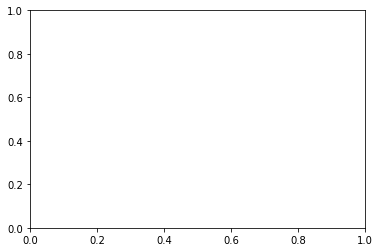

In [33]:
# Now I'm comparing the max peak execution memory of the mapParititons and the map jobs.
mapPartitions_vs_map_df = {
    "MapPartitions": get_cluster_metrics("map-partitions-rdd-cluster-run-output")["appName"].apply(lambda appName:get_max_peakExecutionMemory(get_cluster_spark_stats(appName))),
    "Map": get_cluster_metrics("map-rdd-cluster-run-output")["appName"].apply(lambda appName:get_max_peakExecutionMemory(get_cluster_spark_stats(appName))),  
#     "BasicRDD": get_cluster_metrics("basic-rdd-cluster-run-output")["appName"].apply(lambda appName:get_max_peakExecutionMemory(get_cluster_spark_stats(appName))),  
}
data = pd.DataFrame(mapPartitions_vs_map_df)

generate_graph(data, "Job Number", "Max Peak Execution Memory (bytes)", 
               title="Max Peak Execution Memory Comparison When\nUsing Map vs MapPartitions on Cluster", savefig="mapVsMapPartitionsMaxPeakExecutionMemoryCluster.png")


In [14]:
get_cluster_metrics("basic-rdd-cluster-run-output")["appName"][0]

'BasicRDDRunner-2018-12-17T05:09:59.1545023399Z'

In [30]:
#Let's get metrics on the input of the job
sample_mapPartitionsJob_appName = get_cluster_metrics("map-partitions-rdd-cluster-run-output")["appName"][0]
df = get_cluster_spark_stats(sample_mapPartitionsJob_appName)
sum(df[df["stageId"] == 0]["bytesRead"])


0

In [31]:
sum(df[df["stageId"] == 0]["recordsRead"])

0